# Model Accuracy Comparison

Compare field-level accuracy between the current model and a competing model across 195 mixed documents (invoices, receipts, bank statements).

## Overview
- **Current Model**: Results from our evaluation pipeline
- **Competing Model**: Field-level accuracy from external CSV
- **Schema**: 17 common fields across document types

---
## 1. Setup & Configuration

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from typing import Any
import warnings

warnings.filterwarnings('ignore')

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 3)

In [29]:
# =============================================================================
# CONFIGURATION - Update these paths before running
# =============================================================================

# Path to competing model's field-level accuracy CSV
COMPETING_MODEL_CSV = Path("../output/competing_model_accuracy.csv")

# Path to current model's results
CURRENT_MODEL_CSV = Path("../output/current_model_accuracy.csv")

# Model names for display
# CURRENT_MODEL_NAME = "InternVL3-8B"
# CURRENT_MODEL_NAME = "InternVL3-2B"
CURRENT_MODEL_NAME = "InternVL3.5-8B"
# CURRENT_MODEL_NAME = "Llama-3.2-11B"
# CURRENT_MODEL_NAME = "Llama-4-Scout"
COMPETING_MODEL_NAME = "LayoutLM"

# Output directory for comparison results
OUTPUT_DIR = Path("../output/comparison")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [30]:
# =============================================================================
# SCHEMA FIELDS - 17 fields for comparison
# =============================================================================

SCHEMA_FIELDS = [
    "DOCUMENT_TYPE",
    "BUSINESS_ABN",
    "SUPPLIER_NAME",
    "BUSINESS_ADDRESS",
    "PAYER_NAME",
    "PAYER_ADDRESS",
    "INVOICE_DATE",
    "LINE_ITEM_DESCRIPTIONS",
    "LINE_ITEM_QUANTITIES",
    "LINE_ITEM_PRICES",
    "LINE_ITEM_TOTAL_PRICES",
    "IS_GST_INCLUDED",
    "GST_AMOUNT",
    "TOTAL_AMOUNT",
    "STATEMENT_DATE_RANGE",
    "TRANSACTION_DATES",
    "TRANSACTION_AMOUNTS_PAID",
]

# Field categories for grouped analysis
FIELD_CATEGORIES = {
    "Identity": ["DOCUMENT_TYPE", "BUSINESS_ABN", "SUPPLIER_NAME"],
    "Address": ["BUSINESS_ADDRESS", "PAYER_NAME", "PAYER_ADDRESS"],
    "Dates": ["INVOICE_DATE", "STATEMENT_DATE_RANGE", "TRANSACTION_DATES"],
    "Line Items": ["LINE_ITEM_DESCRIPTIONS", "LINE_ITEM_QUANTITIES", "LINE_ITEM_PRICES", "LINE_ITEM_TOTAL_PRICES"],
    "Financial": ["IS_GST_INCLUDED", "GST_AMOUNT", "TOTAL_AMOUNT", "TRANSACTION_AMOUNTS_PAID"],
}

# Critical fields (require high accuracy)
CRITICAL_FIELDS = ["BUSINESS_ABN", "GST_AMOUNT", "TOTAL_AMOUNT", "SUPPLIER_NAME"]

# =============================================================================
# EXCLUSIVE FIELDS - Capabilities only our model has (not in competing model)
# =============================================================================
# These fields are EXCLUDED from direct comparison metrics but shown separately
# as "Additional Capabilities" to highlight competitive advantage
EXCLUSIVE_FIELDS = ["DOCUMENT_TYPE", "STATEMENT_DATE_RANGE"]

print(f"Schema fields: {len(SCHEMA_FIELDS)}")
print(f"Exclusive fields (our model only): {EXCLUSIVE_FIELDS}")
print(f"Comparable fields: {len(SCHEMA_FIELDS) - len(EXCLUSIVE_FIELDS)}")
print(f"Field categories: {list(FIELD_CATEGORIES.keys())}")

Schema fields: 17
Exclusive fields (our model only): ['DOCUMENT_TYPE', 'STATEMENT_DATE_RANGE']
Comparable fields: 15
Field categories: ['Identity', 'Address', 'Dates', 'Line Items', 'Financial']


---
## 2. Data Loading

In [31]:
def load_competing_model_data(csv_path: Path) -> tuple[dict, dict]:
    """
    Load competing model's field-level F1 scores from CSV.
    
    Returns:
        tuple: (f1_dict, precision_dict) - mapping field names to values
    
    Expected columns: Subset, Field, F1
    For backward compatibility, also checks for 'Accuracy' column.
    """
    df = pd.read_csv(csv_path)
    print(f"Loaded competing model CSV: {csv_path}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    cols_lower = [c.lower() for c in df.columns]
    
    f1_dict = {}
    precision_dict = {}
    
    if 'field' not in cols_lower:
        raise ValueError(f"No 'Field' column found. Columns: {list(df.columns)}")
    
    field_col = df.columns[cols_lower.index('field')]
    
    # Look for F1 column (primary metric)
    f1_col_name = None
    for possible in ['f1', 'f1_score', 'f1-score', 'f1_agnostic', 'accuracy']:
        if possible in cols_lower:
            f1_col_name = df.columns[cols_lower.index(possible)]
            break
    
    if f1_col_name:
        print(f"Using column for comparison: {f1_col_name}")
        for _, row in df.iterrows():
            field = str(row[field_col]).upper()
            f1_dict[field] = pd.to_numeric(row[f1_col_name], errors='coerce')
    else:
        print("No F1 or Accuracy column found")
    
    # Look for Precision column
    if 'precision' in cols_lower:
        prec_col = df.columns[cols_lower.index('precision')]
        for _, row in df.iterrows():
            field = str(row[field_col]).upper()
            precision_dict[field] = pd.to_numeric(row[prec_col], errors='coerce')
    
    print(f"Fields loaded: {len(f1_dict)} F1 values")
    
    return f1_dict, precision_dict

In [32]:
def load_current_model_data(csv_path: Path) -> tuple[dict, dict, set]:
    """
    Load current model's field-level F1 scores and exclusive fields.
    
    Returns:
        tuple: (f1_dict, precision_dict, exclusive_set)
    
    Note: We now use F1 as the primary metric (not accuracy).
    """
    df = pd.read_csv(csv_path)
    print(f"Loaded current model CSV: {csv_path}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    cols_lower = [c.lower() for c in df.columns]
    
    f1_dict = {}
    precision_dict = {}
    exclusive_set = set()
    
    # Check for Field column
    if 'field' not in cols_lower:
        raise ValueError(f"No 'Field' column found. Columns: {list(df.columns)}")
    
    field_col = df.columns[cols_lower.index('field')]
    
    # Look for F1 column (try multiple possible names)
    f1_col_name = None
    for possible in ['f1', 'f1_score', 'f1-score', 'f1_agnostic', 'f1_smart']:
        if possible in cols_lower:
            f1_col_name = df.columns[cols_lower.index(possible)]
            break
    
    if f1_col_name:
        print(f"Found F1 column: {f1_col_name}")
        for _, row in df.iterrows():
            field = str(row[field_col]).upper()
            f1_dict[field] = pd.to_numeric(row[f1_col_name], errors='coerce')
    else:
        print("No F1 column found")
    
    # Look for Precision column
    if 'precision' in cols_lower:
        prec_col = df.columns[cols_lower.index('precision')]
        for _, row in df.iterrows():
            field = str(row[field_col]).upper()
            precision_dict[field] = pd.to_numeric(row[prec_col], errors='coerce')
    
    # Read Exclusive column from CSV
    if 'exclusive' in cols_lower:
        exc_col = df.columns[cols_lower.index('exclusive')]
        for _, row in df.iterrows():
            field = str(row[field_col]).upper()
            exc_val = row[exc_col]
            # Handle string 'True'/'False' or boolean
            if str(exc_val).lower() == 'true' or exc_val == True:
                exclusive_set.add(field)
        print(f"Exclusive fields from CSV: {exclusive_set}")
    
    print(f"Fields loaded: {len(f1_dict)} F1 values")
    
    return f1_dict, precision_dict, exclusive_set

In [33]:
# Load both datasets (F1 scores)
print("=" * 60)
print("LOADING COMPETING MODEL DATA")
print("=" * 60)
competing_f1, competing_precision = load_competing_model_data(COMPETING_MODEL_CSV)

print("" + "=" * 60)
print("LOADING CURRENT MODEL DATA")
print("=" * 60)
current_f1, current_precision, csv_exclusive_fields = load_current_model_data(CURRENT_MODEL_CSV)

# Override EXCLUSIVE_FIELDS with values from CSV if available
if csv_exclusive_fields:
    EXCLUSIVE_FIELDS_DYNAMIC = csv_exclusive_fields
    print(f"Using exclusive fields from CSV: {EXCLUSIVE_FIELDS_DYNAMIC}")
else:
    EXCLUSIVE_FIELDS_DYNAMIC = set(EXCLUSIVE_FIELDS)
    print(f"Using hardcoded exclusive fields: {EXCLUSIVE_FIELDS_DYNAMIC}")

# For backward compatibility with rest of notebook, create accuracy aliases
current_accuracy = current_f1
competing_accuracy = competing_f1

# Summary
print("" + "=" * 60)
print("DATA SUMMARY")
print("=" * 60)
print(f"Current model fields: {len(current_f1)}")
print(f"Competing model fields: {len(competing_f1)}")
common_fields = set(current_f1.keys()) & set(competing_f1.keys())
print(f"Common fields: {len(common_fields)}")
print(f"Exclusive fields: {len(EXCLUSIVE_FIELDS_DYNAMIC)}")

LOADING COMPETING MODEL DATA
Loaded competing model CSV: ../output/competing_model_accuracy.csv
Shape: (17, 4)
Columns: ['Subset', 'Field', 'Accuracy', 'F1']
Using column for comparison: F1
Fields loaded: 16 F1 values
LOADING CURRENT MODEL DATA
Loaded current model CSV: ../output/current_model_accuracy.csv
Shape: (18, 10)
Columns: ['Subset', 'Field', 'Accuracy', 'F1_Smart', 'F1_Binary', 'F1_Aware', 'F1_Agnostic', 'F1_Fuzzy', 'Smart_Method', 'Exclusive']
Found F1 column: F1_Agnostic
Exclusive fields from CSV: {'STATEMENT_DATE_RANGE', 'DOCUMENT_TYPE'}
Fields loaded: 17 F1 values
Using exclusive fields from CSV: {'STATEMENT_DATE_RANGE', 'DOCUMENT_TYPE'}
DATA SUMMARY
Current model fields: 17
Competing model fields: 16
Common fields: 16
Exclusive fields: 2


---
## 3. Data Alignment & Preprocessing

In [34]:
def align_field_data(
    current_acc: dict[str, float], 
    competing_acc: dict[str, float], 
    current_f1: dict[str, float],
    competing_f1: dict[str, float],
    schema_fields: list[str]
) -> pd.DataFrame:
    """
    Align field-level accuracy AND F1 data from both models into a comparison DataFrame.
    
    F1 scores are POSITION-AGNOSTIC for both models, enabling fair comparison.
    Marks fields as 'is_exclusive' if they are in EXCLUSIVE_FIELDS.
    """
    data = []
    
    for field in schema_fields:
        current_accuracy = current_acc.get(field, np.nan)
        competing_accuracy = competing_acc.get(field, np.nan)
        
        # F1 scores (position-agnostic for fair comparison)
        current_f1_val = current_f1.get(field, np.nan) if current_f1 else np.nan
        competing_f1_val = competing_f1.get(field, np.nan) if competing_f1 else np.nan
        
        # Find category for this field
        category = "Other"
        for cat, fields in FIELD_CATEGORIES.items():
            if field in fields:
                category = cat
                break
        
        # Check if this is an exclusive capability (our model only)
        is_exclusive = field in EXCLUSIVE_FIELDS_DYNAMIC
        
        data.append({
            'field': field,
            'category': category,
            'current_accuracy': current_accuracy,
            'competing_accuracy': competing_accuracy,
            'difference': current_accuracy - competing_accuracy if not (np.isnan(current_accuracy) or np.isnan(competing_accuracy)) else np.nan,
            # F1 scores (position-agnostic)
            'current_f1': current_f1_val,
            'competing_f1': competing_f1_val,
            'f1_difference': current_f1_val - competing_f1_val if not (np.isnan(current_f1_val) or np.isnan(competing_f1_val)) else np.nan,
            'is_critical': field in CRITICAL_FIELDS,
            'is_exclusive': is_exclusive,
        })
    
    return pd.DataFrame(data)

In [35]:
# Create aligned comparison DataFrame (with F1 scores)
comparison_df = align_field_data(
    current_accuracy, competing_accuracy, 
    current_f1, competing_f1, 
    SCHEMA_FIELDS
)

# Separate comparable fields from exclusive capabilities
comparable_df = comparison_df[~comparison_df['is_exclusive']].copy()
exclusive_df = comparison_df[comparison_df['is_exclusive']].copy()

print("Field Alignment Summary")
print("=" * 60)
print(f"Total schema fields: {len(SCHEMA_FIELDS)}")
print(f"Comparable fields: {len(comparable_df)}")
print(f"Exclusive capabilities (our model only): {len(exclusive_df)}")

print(f"\nAccuracy data:")
print(f"  Fields with both models: {(comparable_df['current_accuracy'].notna() & comparable_df['competing_accuracy'].notna()).sum()}")

# F1 comparison summary
f1_both = (comparable_df['current_f1'].notna() & comparable_df['competing_f1'].notna()).sum()
print(f"\nF1 Score data (Position-Agnostic):")
print(f"  Fields with both models: {f1_both}")
if f1_both > 0:
    mean_f1_diff = comparable_df['f1_difference'].mean()
    print(f"  Mean F1 difference: {mean_f1_diff:+.1%} (positive = {CURRENT_MODEL_NAME} better)")

# Show exclusive fields
if len(exclusive_df) > 0:
    print(f"\n*** ADDITIONAL CAPABILITIES ({CURRENT_MODEL_NAME} only) ***")
    for _, row in exclusive_df.iterrows():
        acc = f"{row['current_accuracy']:.1%}" if pd.notna(row['current_accuracy']) else "N/A"
        print(f"  - {row['field']}: {acc}")

# Show missing fields (excluding exclusive ones)
missing_current = comparable_df[comparable_df['current_accuracy'].isna()]['field'].tolist()
missing_competing = comparable_df[comparable_df['competing_accuracy'].isna()]['field'].tolist()

if missing_current:
    print(f"\nMissing from current model: {missing_current}")
if missing_competing:
    print(f"Missing from competing model: {missing_competing}")

Field Alignment Summary
Total schema fields: 17
Comparable fields: 15
Exclusive capabilities (our model only): 2

Accuracy data:
  Fields with both models: 15

F1 Score data (Position-Agnostic):
  Fields with both models: 15
  Mean F1 difference: +40.5% (positive = InternVL3.5-8B better)

*** ADDITIONAL CAPABILITIES (InternVL3.5-8B only) ***
  - DOCUMENT_TYPE: 100.0%
  - STATEMENT_DATE_RANGE: 100.0%


In [36]:
# Display the comparison table (comparable fields only)
display_df = comparable_df.copy()
display_df['current_accuracy'] = display_df['current_accuracy'].apply(lambda x: f"{x:.1%}" if pd.notna(x) else "N/A")
display_df['competing_accuracy'] = display_df['competing_accuracy'].apply(lambda x: f"{x:.1%}" if pd.notna(x) else "N/A")
display_df['difference'] = display_df['difference'].apply(lambda x: f"{x:+.1%}" if pd.notna(x) else "N/A")

# Format F1 columns if available
has_f1 = comparable_df['current_f1'].notna().any() or comparable_df['competing_f1'].notna().any()
if has_f1:
    display_df['current_f1'] = display_df['current_f1'].apply(lambda x: f"{x:.1%}" if pd.notna(x) else "N/A")
    display_df['competing_f1'] = display_df['competing_f1'].apply(lambda x: f"{x:.1%}" if pd.notna(x) else "N/A")
    display_df['f1_difference'] = display_df['f1_difference'].apply(lambda x: f"{x:+.1%}" if pd.notna(x) else "N/A")

print("\nField-Level Comparison (Comparable Fields)")
print("=" * 100)

# Show accuracy columns
acc_cols = ['field', 'category', 'current_accuracy', 'competing_accuracy', 'difference', 'is_critical']
print("\n📊 ACCURACY:")
print(display_df[acc_cols].to_string(index=False))

# Show F1 columns if available
if has_f1:
    f1_cols = ['field', 'current_f1', 'competing_f1', 'f1_difference']
    print("\n📈 F1 SCORES (Position-Agnostic):")
    print(display_df[f1_cols].to_string(index=False))

# Display exclusive capabilities separately
if len(exclusive_df) > 0:
    print("\n" + "=" * 100)
    print(f"ADDITIONAL CAPABILITIES ({CURRENT_MODEL_NAME} only - not in {COMPETING_MODEL_NAME})")
    print("=" * 100)
    exc_display = exclusive_df.copy()
    exc_display['current_accuracy'] = exc_display['current_accuracy'].apply(lambda x: f"{x:.1%}" if pd.notna(x) else "N/A")
    if has_f1:
        exc_display['current_f1'] = exc_display['current_f1'].apply(lambda x: f"{x:.1%}" if pd.notna(x) else "N/A")
        print(exc_display[['field', 'category', 'current_accuracy', 'current_f1']].to_string(index=False))
    else:
        print(exc_display[['field', 'category', 'current_accuracy']].to_string(index=False))


Field-Level Comparison (Comparable Fields)

📊 ACCURACY:
                   field   category current_accuracy competing_accuracy difference  is_critical
            BUSINESS_ABN   Identity           100.0%              20.4%     +79.6%         True
           SUPPLIER_NAME   Identity           100.0%              58.8%     +41.2%         True
        BUSINESS_ADDRESS    Address            83.3%              47.9%     +35.4%        False
              PAYER_NAME    Address           100.0%              89.5%     +10.5%        False
           PAYER_ADDRESS    Address           100.0%              46.3%     +53.7%        False
            INVOICE_DATE      Dates            83.3%              83.3%      +0.1%        False
  LINE_ITEM_DESCRIPTIONS Line Items            65.3%              55.8%      +9.5%        False
    LINE_ITEM_QUANTITIES Line Items           100.0%              15.1%     +84.9%        False
        LINE_ITEM_PRICES Line Items           100.0%              17.6%     +82

---
## 4. Aggregate Metrics

In [37]:
def calculate_aggregate_metrics(df: pd.DataFrame, exclusive_df: pd.DataFrame = None) -> dict[str, Any]:
    """
    Calculate aggregate comparison metrics including F1 scores.
    
    Only uses comparable fields (excludes exclusive capabilities) for fair comparison.
    F1 metrics are included when both models have F1 data.
    """
    
    # Filter to comparable fields with both accuracy values
    comparable_only = df[~df['is_exclusive']] if 'is_exclusive' in df.columns else df
    valid_df = comparable_only.dropna(subset=['current_accuracy', 'competing_accuracy'])
    
    metrics = {
        'n_fields_compared': len(valid_df),
        'n_exclusive_fields': len(exclusive_df) if exclusive_df is not None else 0,
        
        # Current model accuracy metrics (comparable fields only)
        'current_mean': valid_df['current_accuracy'].mean(),
        'current_median': valid_df['current_accuracy'].median(),
        'current_std': valid_df['current_accuracy'].std(),
        'current_min': valid_df['current_accuracy'].min(),
        'current_max': valid_df['current_accuracy'].max(),
        
        # Competing model accuracy metrics
        'competing_mean': valid_df['competing_accuracy'].mean(),
        'competing_median': valid_df['competing_accuracy'].median(),
        'competing_std': valid_df['competing_accuracy'].std(),
        'competing_min': valid_df['competing_accuracy'].min(),
        'competing_max': valid_df['competing_accuracy'].max(),
        
        # Accuracy comparison metrics
        'mean_difference': valid_df['difference'].mean(),
        'fields_current_better': (valid_df['difference'] > 0).sum(),
        'fields_competing_better': (valid_df['difference'] < 0).sum(),
        'fields_equal': (valid_df['difference'] == 0).sum(),
        
        # Critical fields (from comparable only)
        'critical_current_mean': valid_df[valid_df['is_critical']]['current_accuracy'].mean(),
        'critical_competing_mean': valid_df[valid_df['is_critical']]['competing_accuracy'].mean(),
    }
    
    # F1 Score metrics (position-agnostic for fair comparison)
    f1_valid = comparable_only.dropna(subset=['current_f1', 'competing_f1'])
    metrics['n_fields_with_f1'] = len(f1_valid)
    
    if len(f1_valid) > 0:
        metrics['current_f1_mean'] = f1_valid['current_f1'].mean()
        metrics['competing_f1_mean'] = f1_valid['competing_f1'].mean()
        metrics['f1_mean_difference'] = f1_valid['f1_difference'].mean()
        metrics['f1_fields_current_better'] = (f1_valid['f1_difference'] > 0).sum()
        metrics['f1_fields_competing_better'] = (f1_valid['f1_difference'] < 0).sum()
    else:
        metrics['current_f1_mean'] = np.nan
        metrics['competing_f1_mean'] = np.nan
        metrics['f1_mean_difference'] = np.nan
        metrics['f1_fields_current_better'] = 0
        metrics['f1_fields_competing_better'] = 0
    
    # Add exclusive capabilities metrics
    if exclusive_df is not None and len(exclusive_df) > 0:
        exclusive_with_data = exclusive_df[exclusive_df['current_accuracy'].notna()]
        metrics['exclusive_fields'] = exclusive_df['field'].tolist()
        metrics['exclusive_mean'] = exclusive_with_data['current_accuracy'].mean() if len(exclusive_with_data) > 0 else np.nan
    else:
        metrics['exclusive_fields'] = []
        metrics['exclusive_mean'] = np.nan
    
    return metrics

In [38]:
metrics = calculate_aggregate_metrics(comparison_df, exclusive_df)

print("\n" + "=" * 60)
print("AGGREGATE METRICS SUMMARY")
print("=" * 60)

print(f"\nComparable Fields: {metrics['n_fields_compared']}")
print(f"Additional Capabilities ({CURRENT_MODEL_NAME} only): {metrics['n_exclusive_fields']}")

print(f"\n--- ACCURACY METRICS ---")
print(f"\n{CURRENT_MODEL_NAME} (comparable fields):")
print(f"  Mean Accuracy:   {metrics['current_mean']:.1%}")
print(f"  Median Accuracy: {metrics['current_median']:.1%}")
print(f"  Std Dev:         {metrics['current_std']:.1%}")
print(f"  Range:           {metrics['current_min']:.1%} - {metrics['current_max']:.1%}")

print(f"\n{COMPETING_MODEL_NAME}:")
print(f"  Mean Accuracy:   {metrics['competing_mean']:.1%}")
print(f"  Median Accuracy: {metrics['competing_median']:.1%}")
print(f"  Std Dev:         {metrics['competing_std']:.1%}")
print(f"  Range:           {metrics['competing_min']:.1%} - {metrics['competing_max']:.1%}")

print(f"\nAccuracy Comparison:")
print(f"  Mean Difference: {metrics['mean_difference']:+.1%} (positive = {CURRENT_MODEL_NAME} better)")
print(f"  Fields where {CURRENT_MODEL_NAME} better: {metrics['fields_current_better']}")
print(f"  Fields where {COMPETING_MODEL_NAME} better: {metrics['fields_competing_better']}")
print(f"  Fields equal: {metrics['fields_equal']}")

print(f"\nCritical Fields (ABN, GST, Total, Supplier):")
print(f"  {CURRENT_MODEL_NAME} Mean:   {metrics['critical_current_mean']:.1%}")
print(f"  {COMPETING_MODEL_NAME} Mean: {metrics['critical_competing_mean']:.1%}")

# F1 Score comparison (if available)
if metrics['n_fields_with_f1'] > 0:
    print(f"\n--- F1 SCORE METRICS (Position-Agnostic) ---")
    print(f"\nFields with F1 comparison: {metrics['n_fields_with_f1']}")
    print(f"\n{CURRENT_MODEL_NAME}:")
    print(f"  Mean F1: {metrics['current_f1_mean']:.1%}")
    print(f"\n{COMPETING_MODEL_NAME}:")
    print(f"  Mean F1: {metrics['competing_f1_mean']:.1%}")
    print(f"\nF1 Comparison:")
    print(f"  Mean F1 Difference: {metrics['f1_mean_difference']:+.1%}")
    print(f"  Fields where {CURRENT_MODEL_NAME} better: {metrics['f1_fields_current_better']}")
    print(f"  Fields where {COMPETING_MODEL_NAME} better: {metrics['f1_fields_competing_better']}")
else:
    print(f"\n--- F1 SCORES ---")
    print("  No F1 comparison available (add F1 columns to both CSV files)")

if metrics['n_exclusive_fields'] > 0:
    print(f"\n*** ADDITIONAL CAPABILITIES ({CURRENT_MODEL_NAME} only) ***")
    print(f"  Fields: {', '.join(metrics['exclusive_fields'])}")
    if not np.isnan(metrics['exclusive_mean']):
        print(f"  Mean Accuracy: {metrics['exclusive_mean']:.1%}")


AGGREGATE METRICS SUMMARY

Comparable Fields: 15
Additional Capabilities (InternVL3.5-8B only): 2

--- ACCURACY METRICS ---

InternVL3.5-8B (comparable fields):
  Mean Accuracy:   95.1%
  Median Accuracy: 100.0%
  Std Dev:         10.1%
  Range:           65.3% - 100.0%

LayoutLM:
  Mean Accuracy:   54.6%
  Median Accuracy: 55.8%
  Std Dev:         23.3%
  Range:           15.1% - 89.5%

Accuracy Comparison:
  Mean Difference: +40.5% (positive = InternVL3.5-8B better)
  Fields where InternVL3.5-8B better: 15
  Fields where LayoutLM better: 0
  Fields equal: 0

Critical Fields (ABN, GST, Total, Supplier):
  InternVL3.5-8B Mean:   100.0%
  LayoutLM Mean: 51.7%

--- F1 SCORE METRICS (Position-Agnostic) ---

Fields with F1 comparison: 15

InternVL3.5-8B:
  Mean F1: 95.1%

LayoutLM:
  Mean F1: 54.6%

F1 Comparison:
  Mean F1 Difference: +40.5%
  Fields where InternVL3.5-8B better: 15
  Fields where LayoutLM better: 0

*** ADDITIONAL CAPABILITIES (InternVL3.5-8B only) ***
  Fields: DOCUMENT

---
## 5. Statistical Tests

In [39]:
def run_statistical_tests(df: pd.DataFrame) -> dict[str, Any]:
    """
    Run statistical significance tests on accuracy differences.
    
    Uses only comparable fields (excludes exclusive capabilities).
    """
    
    # Filter to comparable fields only
    comparable_only = df[~df['is_exclusive']] if 'is_exclusive' in df.columns else df
    valid_df = comparable_only.dropna(subset=['current_accuracy', 'competing_accuracy'])
    current = valid_df['current_accuracy'].values
    competing = valid_df['competing_accuracy'].values
    
    results = {}
    
    # Paired t-test (assumes normality)
    t_stat, t_pvalue = stats.ttest_rel(current, competing)
    results['paired_ttest'] = {'statistic': t_stat, 'pvalue': t_pvalue}
    
    # Wilcoxon signed-rank test (non-parametric alternative)
    # Only works if there are non-zero differences
    differences = current - competing
    non_zero_diff = differences[differences != 0]
    if len(non_zero_diff) > 0:
        w_stat, w_pvalue = stats.wilcoxon(non_zero_diff)
        results['wilcoxon'] = {'statistic': w_stat, 'pvalue': w_pvalue}
    else:
        results['wilcoxon'] = {'statistic': np.nan, 'pvalue': 1.0}
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((current.std()**2 + competing.std()**2) / 2)
    cohens_d = (current.mean() - competing.mean()) / pooled_std if pooled_std > 0 else 0
    results['cohens_d'] = cohens_d
    
    # Bootstrap confidence interval for mean difference
    n_bootstrap = 10000
    bootstrap_diffs = []
    n = len(current)
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        boot_diff = current[idx].mean() - competing[idx].mean()
        bootstrap_diffs.append(boot_diff)
    
    ci_95 = np.percentile(bootstrap_diffs, [2.5, 97.5])
    results['bootstrap_ci_95'] = ci_95
    
    return results

In [40]:
stat_results = run_statistical_tests(comparison_df)

print("\n" + "=" * 60)
print("STATISTICAL SIGNIFICANCE TESTS")
print("=" * 60)

print(f"\nPaired t-test:")
print(f"  t-statistic: {stat_results['paired_ttest']['statistic']:.4f}")
print(f"  p-value:     {stat_results['paired_ttest']['pvalue']:.4f}")
sig_t = "YES" if stat_results['paired_ttest']['pvalue'] < 0.05 else "NO"
print(f"  Significant at α=0.05: {sig_t}")

print(f"\nWilcoxon signed-rank test (non-parametric):")
print(f"  W-statistic: {stat_results['wilcoxon']['statistic']:.4f}")
print(f"  p-value:     {stat_results['wilcoxon']['pvalue']:.4f}")
sig_w = "YES" if stat_results['wilcoxon']['pvalue'] < 0.05 else "NO"
print(f"  Significant at α=0.05: {sig_w}")

print(f"\nEffect Size:")
print(f"  Cohen's d: {stat_results['cohens_d']:.4f}")
effect_interp = "negligible" if abs(stat_results['cohens_d']) < 0.2 else \
                "small" if abs(stat_results['cohens_d']) < 0.5 else \
                "medium" if abs(stat_results['cohens_d']) < 0.8 else "large"
print(f"  Interpretation: {effect_interp}")

print(f"\n95% Bootstrap Confidence Interval for Mean Difference:")
print(f"  [{stat_results['bootstrap_ci_95'][0]:+.1%}, {stat_results['bootstrap_ci_95'][1]:+.1%}]")
contains_zero = stat_results['bootstrap_ci_95'][0] <= 0 <= stat_results['bootstrap_ci_95'][1]
print(f"  Contains zero: {'YES (not significant)' if contains_zero else 'NO (significant)'}")


STATISTICAL SIGNIFICANCE TESTS

Paired t-test:
  t-statistic: 5.9033
  p-value:     0.0000
  Significant at α=0.05: YES

Wilcoxon signed-rank test (non-parametric):
  W-statistic: 0.0000
  p-value:     0.0001
  Significant at α=0.05: YES

Effect Size:
  Cohen's d: 2.3360
  Interpretation: large

95% Bootstrap Confidence Interval for Mean Difference:
  [+27.8%, +53.6%]
  Contains zero: NO (significant)


---
## 6. Visualizations

In [41]:
# Prepare data for plotting - use COMPARABLE fields only (exclude exclusive capabilities)
plot_df = comparable_df.dropna(subset=['current_accuracy', 'competing_accuracy']).copy()
plot_df = plot_df.sort_values('current_accuracy', ascending=True)

print(f"Plotting {len(plot_df)} comparable fields (excluding {len(exclusive_df)} exclusive capabilities)")

Plotting 15 comparable fields (excluding 2 exclusive capabilities)


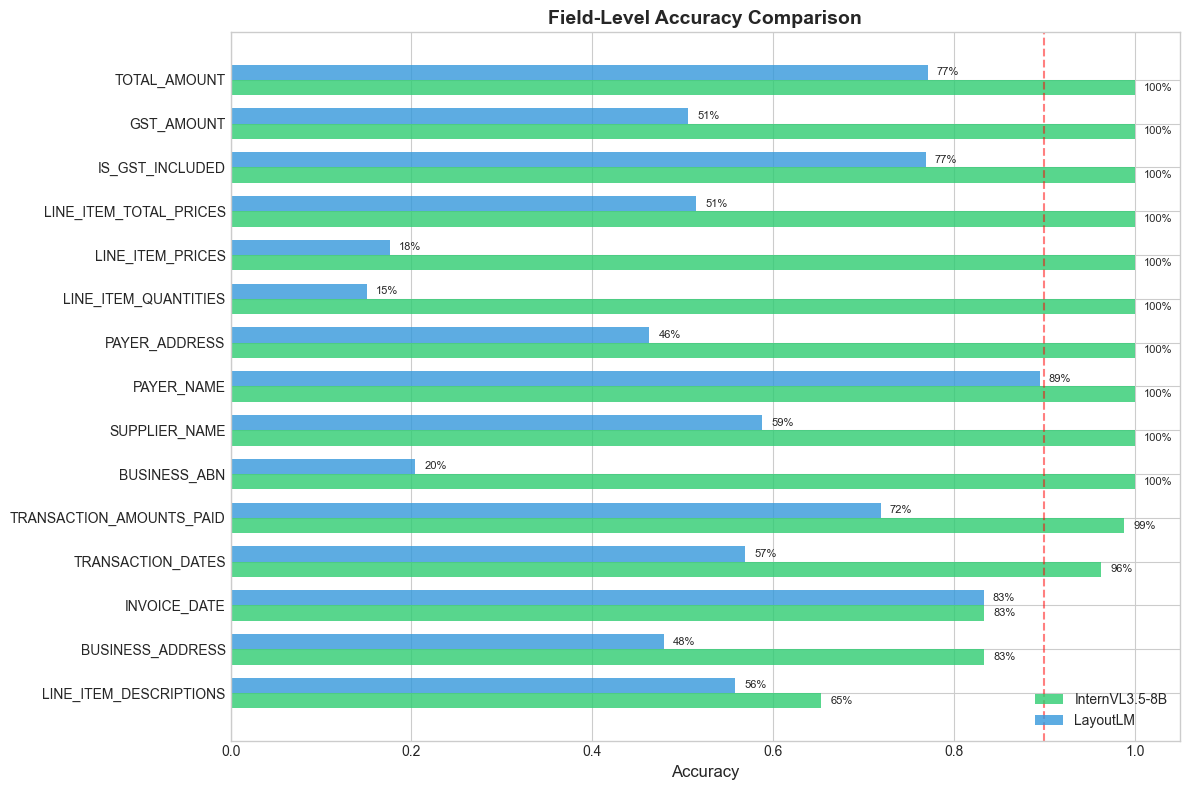

In [42]:
# Figure 1: Side-by-side bar chart
fig, ax = plt.subplots(figsize=(12, 8))

y_pos = np.arange(len(plot_df))
bar_height = 0.35

bars1 = ax.barh(y_pos - bar_height/2, plot_df['current_accuracy'], bar_height, 
                label=CURRENT_MODEL_NAME, color='#2ecc71', alpha=0.8)
bars2 = ax.barh(y_pos + bar_height/2, plot_df['competing_accuracy'], bar_height,
                label=COMPETING_MODEL_NAME, color='#3498db', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(plot_df['field'])
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_title('Field-Level Accuracy Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim(0, 1.05)
ax.axvline(x=0.9, color='red', linestyle='--', alpha=0.5, label='90% threshold')

# Add value labels
for bar, val in zip(bars1, plot_df['current_accuracy']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.0%}', 
            va='center', fontsize=8)
for bar, val in zip(bars2, plot_df['competing_accuracy']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.0%}', 
            va='center', fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_comparison_bars.png', dpi=150, bbox_inches='tight')
plt.show()

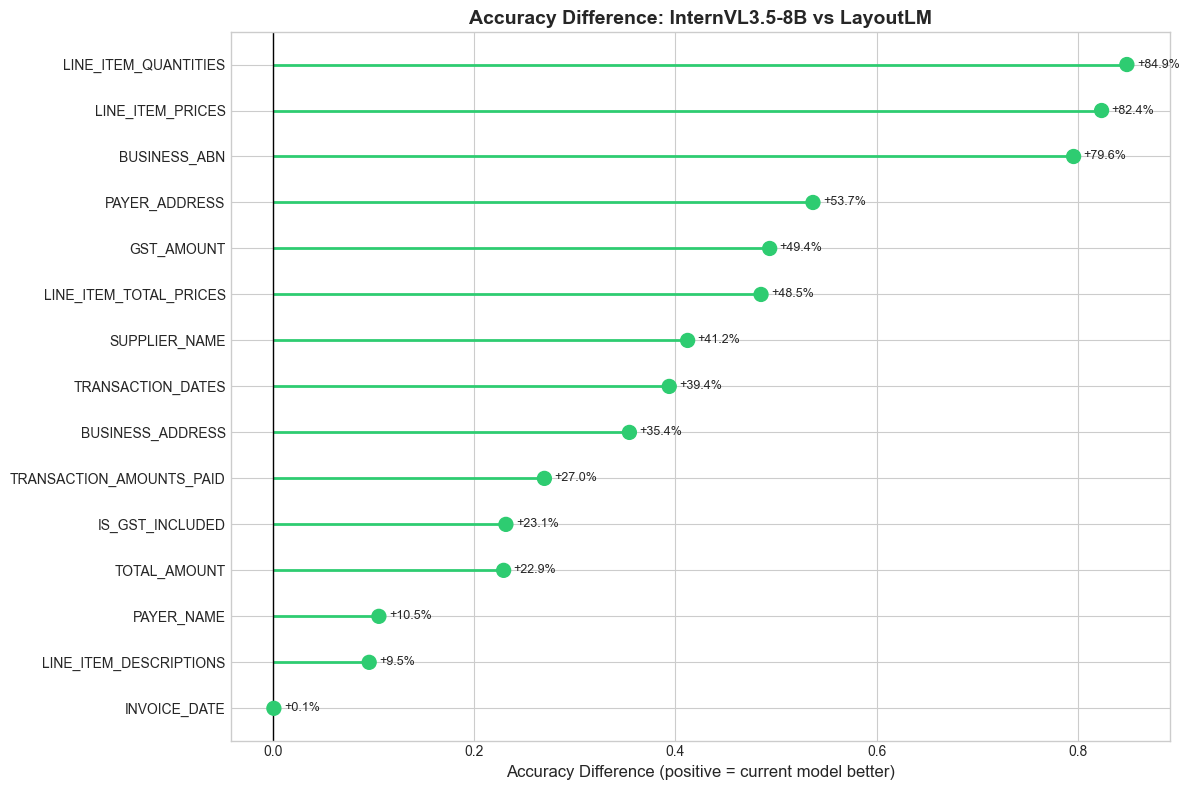

In [43]:
# Figure 2: Difference chart (lollipop plot)
fig, ax = plt.subplots(figsize=(12, 8))

# Sort by difference
diff_df = plot_df.sort_values('difference')
y_pos = np.arange(len(diff_df))

colors = ['#2ecc71' if d >= 0 else '#e74c3c' for d in diff_df['difference']]

ax.hlines(y=y_pos, xmin=0, xmax=diff_df['difference'], color=colors, linewidth=2)
ax.scatter(diff_df['difference'], y_pos, color=colors, s=100, zorder=3)

ax.set_yticks(y_pos)
ax.set_yticklabels(diff_df['field'])
ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Accuracy Difference (positive = current model better)', fontsize=12)
ax.set_title(f'Accuracy Difference: {CURRENT_MODEL_NAME} vs {COMPETING_MODEL_NAME}', 
             fontsize=14, fontweight='bold')

# Add value labels
for y, diff in zip(y_pos, diff_df['difference']):
    ax.text(diff + 0.01 if diff >= 0 else diff - 0.01, y, f'{diff:+.1%}',
            va='center', ha='left' if diff >= 0 else 'right', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_difference_lollipop.png', dpi=150, bbox_inches='tight')
plt.show()

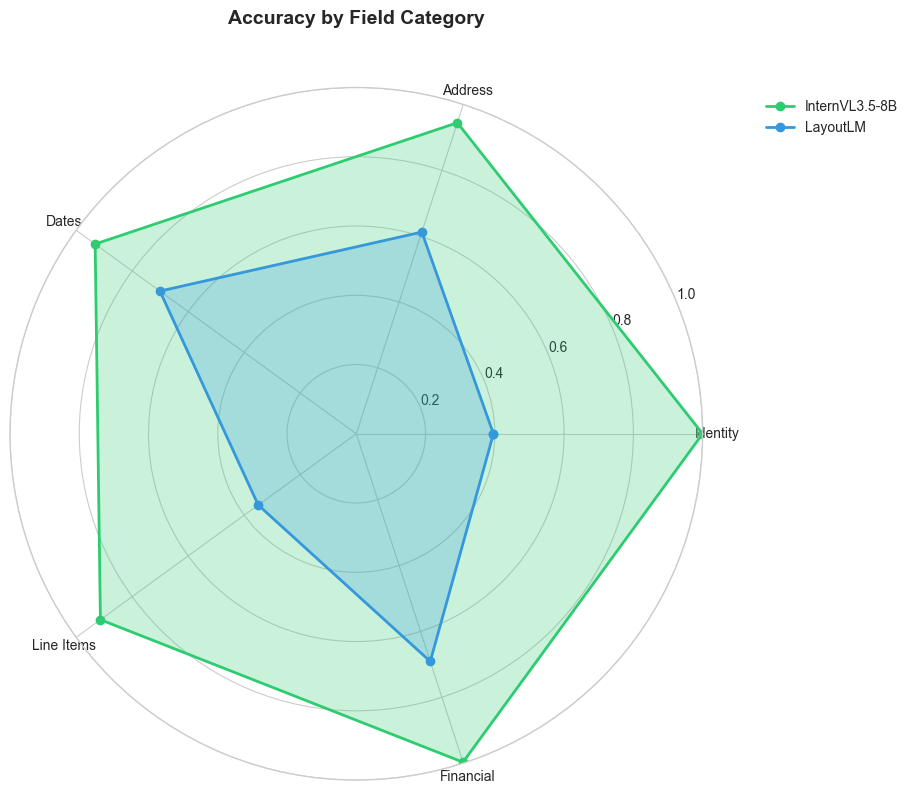

In [44]:
# Figure 3: Radar/Spider chart by category
def plot_radar_chart(df: pd.DataFrame, categories: dict, ax=None):
    """Plot radar chart comparing models by field category."""
    
    # Calculate category averages
    cat_data = []
    for cat, fields in categories.items():
        cat_df = df[df['field'].isin(fields)]
        if len(cat_df) > 0:
            cat_data.append({
                'category': cat,
                'current': cat_df['current_accuracy'].mean(),
                'competing': cat_df['competing_accuracy'].mean()
            })
    
    cat_df = pd.DataFrame(cat_data)
    
    # Radar chart setup
    categories_list = cat_df['category'].tolist()
    N = len(categories_list)
    
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot current model
    values = cat_df['current'].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=CURRENT_MODEL_NAME, color='#2ecc71')
    ax.fill(angles, values, alpha=0.25, color='#2ecc71')
    
    # Plot competing model
    values = cat_df['competing'].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=COMPETING_MODEL_NAME, color='#3498db')
    ax.fill(angles, values, alpha=0.25, color='#3498db')
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories_list)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    return ax

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))
plot_radar_chart(comparison_df, FIELD_CATEGORIES, ax)
plt.title('Accuracy by Field Category', fontsize=14, fontweight='bold', y=1.08)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_radar_chart.png', dpi=150, bbox_inches='tight')
plt.show()

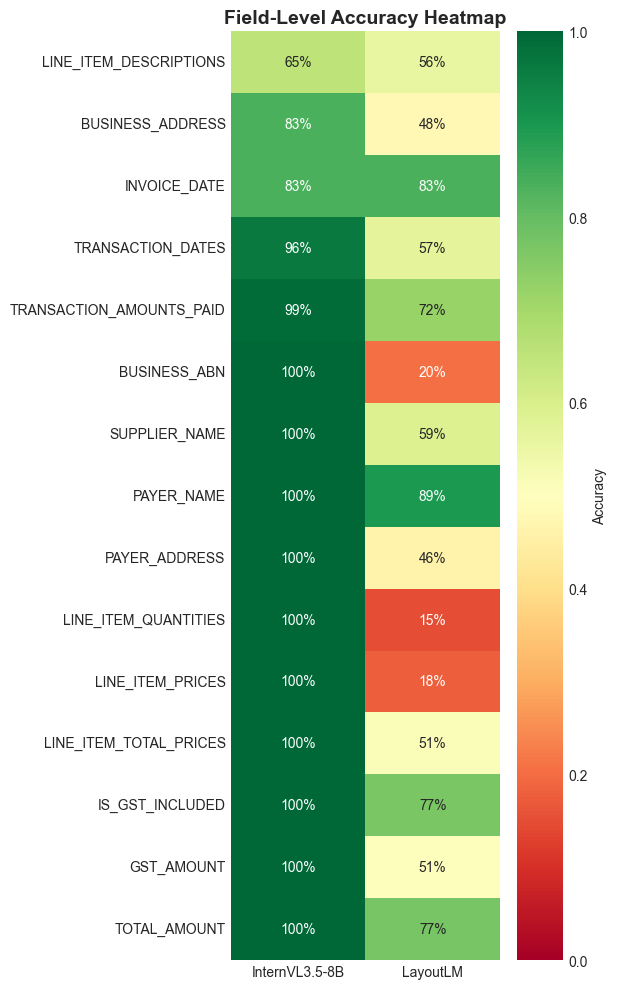

In [45]:
# Figure 4: Heatmap of accuracy values
fig, ax = plt.subplots(figsize=(6, 10))

heatmap_data = plot_df[['current_accuracy', 'competing_accuracy']].copy()
heatmap_data.index = plot_df['field']
heatmap_data.columns = [CURRENT_MODEL_NAME, COMPETING_MODEL_NAME]

sns.heatmap(heatmap_data, annot=True, fmt='.0%', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_title('Field-Level Accuracy Heatmap', fontsize=14, fontweight='bold')
ax.set_ylabel('')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

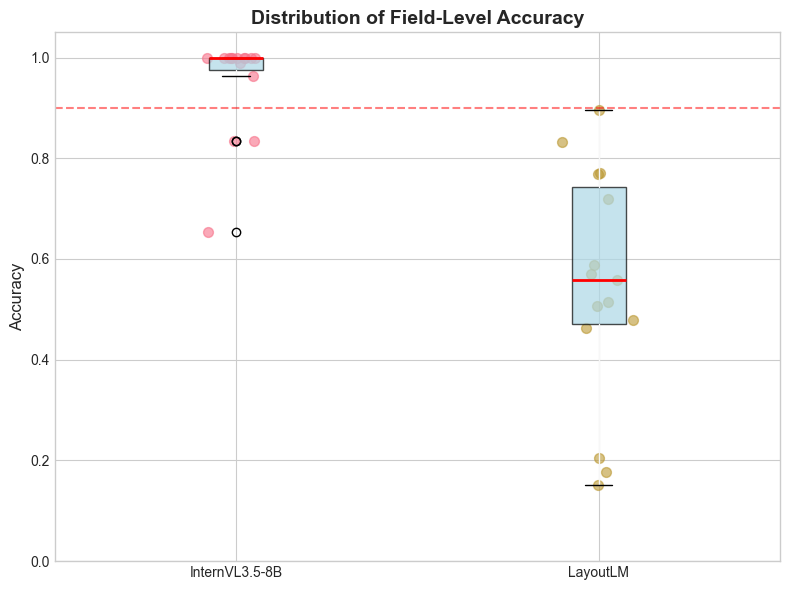

In [46]:
# Figure 5: Box plot comparison
fig, ax = plt.subplots(figsize=(8, 6))

box_data = pd.DataFrame({
    CURRENT_MODEL_NAME: plot_df['current_accuracy'],
    COMPETING_MODEL_NAME: plot_df['competing_accuracy']
})

box_data.boxplot(ax=ax, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))

# Add individual points
for i, col in enumerate(box_data.columns, 1):
    y = box_data[col].dropna()
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=50)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Distribution of Field-Level Accuracy', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.05)
ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% threshold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

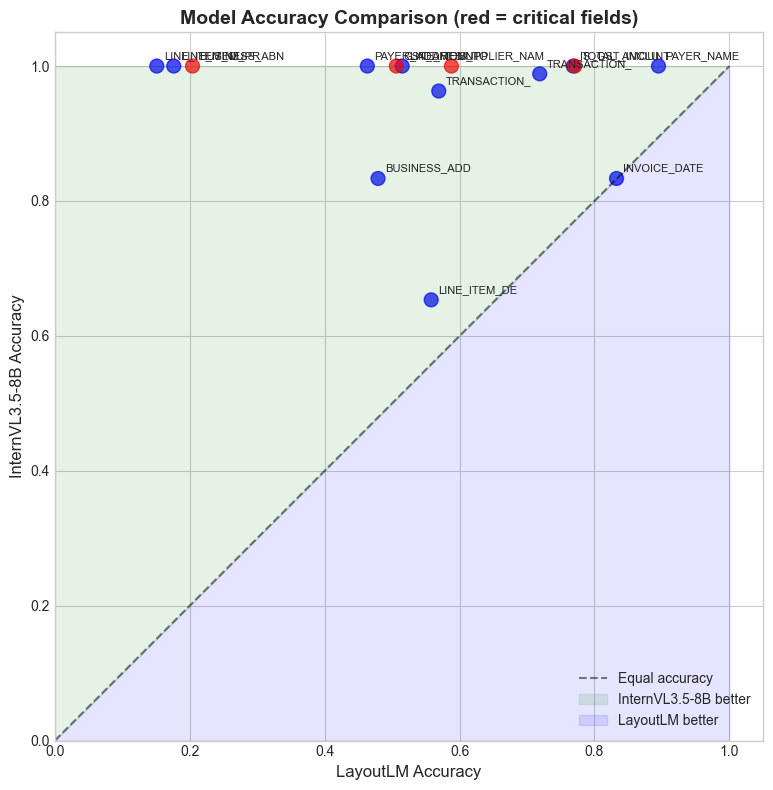

In [47]:
# Figure 6: Scatter plot with identity line
fig, ax = plt.subplots(figsize=(8, 8))

# Plot points
colors = ['red' if c else 'blue' for c in plot_df['is_critical']]
ax.scatter(plot_df['competing_accuracy'], plot_df['current_accuracy'], 
           c=colors, s=100, alpha=0.7)

# Add field labels
for _, row in plot_df.iterrows():
    ax.annotate(row['field'][:12], (row['competing_accuracy'], row['current_accuracy']),
                textcoords="offset points", xytext=(5, 5), fontsize=8)

# Identity line
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Equal accuracy')

# Fill regions
ax.fill_between([0, 1], [0, 1], [1, 1], alpha=0.1, color='green', label=f'{CURRENT_MODEL_NAME} better')
ax.fill_between([0, 1], [0, 0], [0, 1], alpha=0.1, color='blue', label=f'{COMPETING_MODEL_NAME} better')

ax.set_xlabel(f'{COMPETING_MODEL_NAME} Accuracy', fontsize=12)
ax.set_ylabel(f'{CURRENT_MODEL_NAME} Accuracy', fontsize=12)
ax.set_title('Model Accuracy Comparison (red = critical fields)', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right')
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

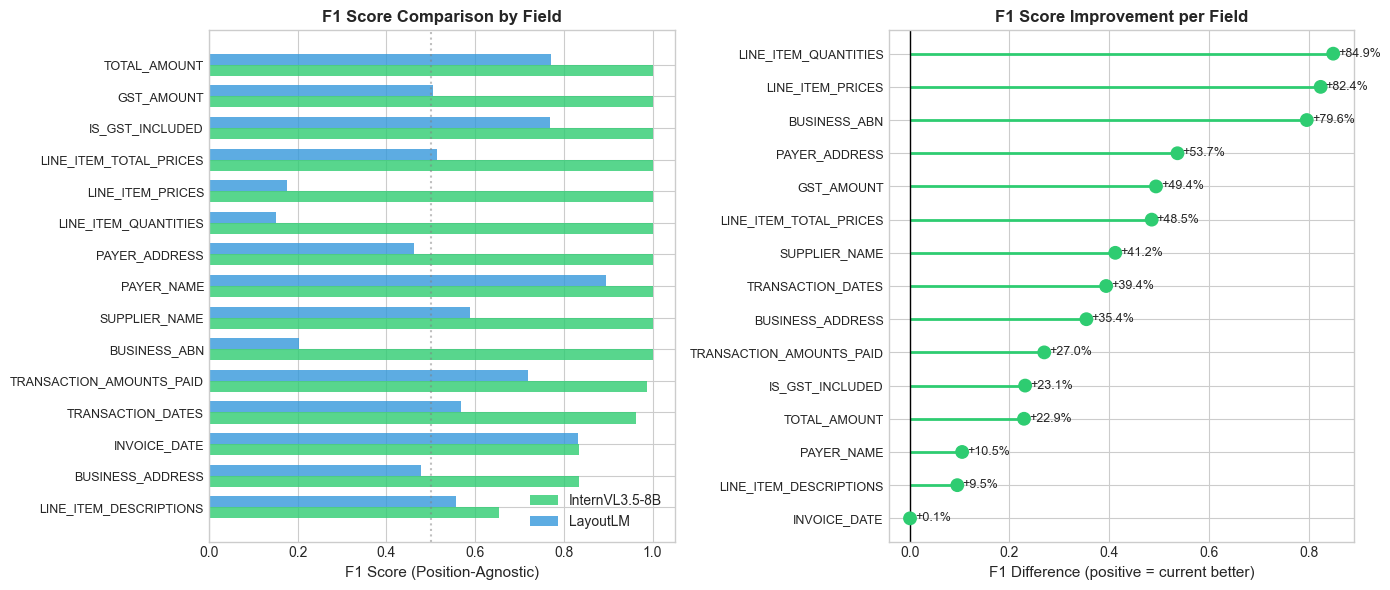


F1 Score Summary (Position-Agnostic):
  Fields compared: 15
  InternVL3.5-8B mean F1: 95.1%
  LayoutLM mean F1: 54.6%
  Mean F1 difference: +40.5%


In [48]:
# Figure 7: F1 Score Comparison (if F1 data available)
f1_plot_df = comparable_df.dropna(subset=['current_f1', 'competing_f1']).copy()

if len(f1_plot_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: F1 bar comparison
    ax1 = axes[0]
    f1_sorted = f1_plot_df.sort_values('current_f1', ascending=True)
    y_pos = np.arange(len(f1_sorted))
    bar_height = 0.35
    
    ax1.barh(y_pos - bar_height/2, f1_sorted['current_f1'], bar_height, 
             label=CURRENT_MODEL_NAME, color='#2ecc71', alpha=0.8)
    ax1.barh(y_pos + bar_height/2, f1_sorted['competing_f1'], bar_height,
             label=COMPETING_MODEL_NAME, color='#3498db', alpha=0.8)
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(f1_sorted['field'], fontsize=9)
    ax1.set_xlabel('F1 Score (Position-Agnostic)', fontsize=11)
    ax1.set_title('F1 Score Comparison by Field', fontsize=12, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.set_xlim(0, 1.05)
    ax1.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
    
    # Right: F1 difference lollipop
    ax2 = axes[1]
    f1_diff_sorted = f1_plot_df.sort_values('f1_difference')
    y_diff = np.arange(len(f1_diff_sorted))
    diff_colors = ['#2ecc71' if d >= 0 else '#e74c3c' for d in f1_diff_sorted['f1_difference']]
    
    ax2.hlines(y=y_diff, xmin=0, xmax=f1_diff_sorted['f1_difference'], color=diff_colors, linewidth=2)
    ax2.scatter(f1_diff_sorted['f1_difference'], y_diff, color=diff_colors, s=80, zorder=3)
    ax2.axvline(x=0, color='black', linewidth=1)
    
    ax2.set_yticks(y_diff)
    ax2.set_yticklabels(f1_diff_sorted['field'], fontsize=9)
    ax2.set_xlabel('F1 Difference (positive = current better)', fontsize=11)
    ax2.set_title('F1 Score Improvement per Field', fontsize=12, fontweight='bold')
    
    # Add value labels
    for y, diff in zip(y_diff, f1_diff_sorted['f1_difference']):
        ax2.text(diff + 0.01 if diff >= 0 else diff - 0.01, y, f'{diff:+.1%}',
                va='center', ha='left' if diff >= 0 else 'right', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'f1_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Summary
    print(f"\nF1 Score Summary (Position-Agnostic):")
    print(f"  Fields compared: {len(f1_plot_df)}")
    print(f"  {CURRENT_MODEL_NAME} mean F1: {f1_plot_df['current_f1'].mean():.1%}")
    print(f"  {COMPETING_MODEL_NAME} mean F1: {f1_plot_df['competing_f1'].mean():.1%}")
    print(f"  Mean F1 difference: {f1_plot_df['f1_difference'].mean():+.1%}")
else:
    print("No F1 comparison chart generated - F1 data not available for both models")
    print("To enable F1 comparison:")
    print("  1. Run harvest notebook to generate current model F1 scores")
    print("  2. Add F1 column to competing_model_accuracy.csv")

---
## 7. Category-Level Analysis

In [49]:
def analyze_by_category(df: pd.DataFrame, categories: dict) -> pd.DataFrame:
    """Analyze accuracy by field category."""
    results = []
    
    for cat, fields in categories.items():
        cat_df = df[df['field'].isin(fields)].dropna(subset=['current_accuracy', 'competing_accuracy'])
        
        if len(cat_df) > 0:
            results.append({
                'category': cat,
                'n_fields': len(cat_df),
                'current_mean': cat_df['current_accuracy'].mean(),
                'competing_mean': cat_df['competing_accuracy'].mean(),
                'difference': cat_df['difference'].mean(),
                'current_wins': (cat_df['difference'] > 0).sum(),
                'competing_wins': (cat_df['difference'] < 0).sum(),
            })
    
    return pd.DataFrame(results)

In [50]:
category_analysis = analyze_by_category(comparison_df, FIELD_CATEGORIES)

print("\n" + "=" * 80)
print("CATEGORY-LEVEL ANALYSIS")
print("=" * 80)

for _, row in category_analysis.iterrows():
    print(f"\n{row['category']} ({row['n_fields']} fields):")
    print(f"  {CURRENT_MODEL_NAME}:   {row['current_mean']:.1%}")
    print(f"  {COMPETING_MODEL_NAME}: {row['competing_mean']:.1%}")
    print(f"  Difference: {row['difference']:+.1%}")
    print(f"  Winner breakdown: {CURRENT_MODEL_NAME}={row['current_wins']}, {COMPETING_MODEL_NAME}={row['competing_wins']}")


CATEGORY-LEVEL ANALYSIS

Identity (2 fields):
  InternVL3.5-8B:   100.0%
  LayoutLM: 39.6%
  Difference: +60.4%
  Winner breakdown: InternVL3.5-8B=2, LayoutLM=0

Address (3 fields):
  InternVL3.5-8B:   94.4%
  LayoutLM: 61.2%
  Difference: +33.2%
  Winner breakdown: InternVL3.5-8B=3, LayoutLM=0

Dates (2 fields):
  InternVL3.5-8B:   89.8%
  LayoutLM: 70.1%
  Difference: +19.7%
  Winner breakdown: InternVL3.5-8B=2, LayoutLM=0

Line Items (4 fields):
  InternVL3.5-8B:   91.3%
  LayoutLM: 35.0%
  Difference: +56.3%
  Winner breakdown: InternVL3.5-8B=4, LayoutLM=0

Financial (4 fields):
  InternVL3.5-8B:   99.7%
  LayoutLM: 69.1%
  Difference: +30.6%
  Winner breakdown: InternVL3.5-8B=4, LayoutLM=0


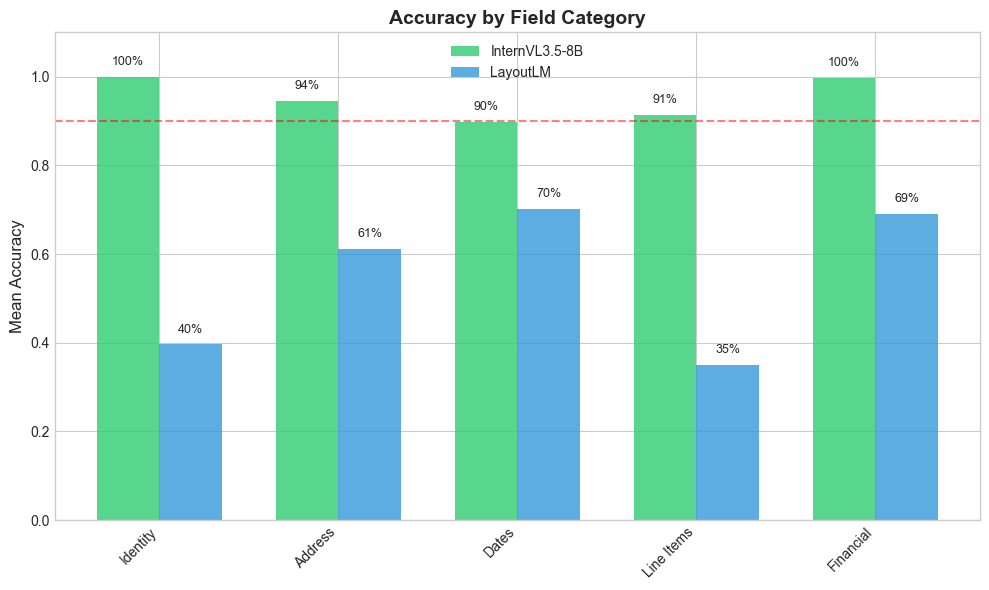

In [51]:
# Category comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(category_analysis))
width = 0.35

bars1 = ax.bar(x - width/2, category_analysis['current_mean'], width, 
               label=CURRENT_MODEL_NAME, color='#2ecc71', alpha=0.8)
bars2 = ax.bar(x + width/2, category_analysis['competing_mean'], width,
               label=COMPETING_MODEL_NAME, color='#3498db', alpha=0.8)

ax.set_ylabel('Mean Accuracy', fontsize=12)
ax.set_title('Accuracy by Field Category', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(category_analysis['category'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.5)

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{bar.get_height():.0%}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{bar.get_height():.0%}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'accuracy_by_category.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. A4 Dashboard Summary

Single-page dashboard suitable for printing or reports.

Saved: ../output/comparison/comparison_dashboard_a4.png
Saved: ../output/comparison/comparison_dashboard_a4.pdf


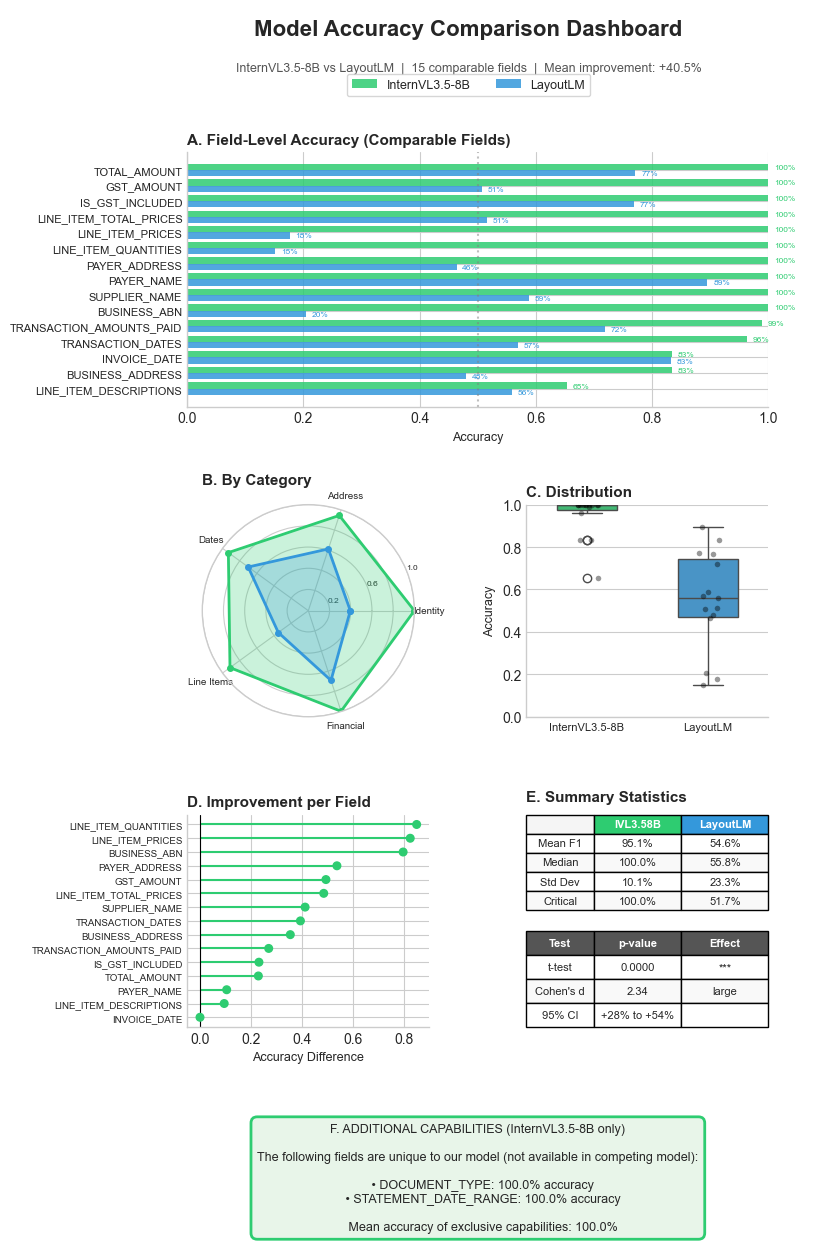

In [52]:
# =============================================================================
# A4 PORTRAIT DASHBOARD - Single page summary with Additional Capabilities
# =============================================================================
# A4 portrait: 8.27 x 11.69 inches, using 7.5 x 10.5 for margins

fig = plt.figure(figsize=(7.5, 13), facecolor='white')

# Create grid: 4 rows with different heights
gs = fig.add_gridspec(4, 2, height_ratios=[1.2, 1, 1, 0.5], hspace=0.5, wspace=0.4, top=0.87, bottom=0.04)

# --- Title & Summary Stats (top spanning both columns) ---
ax_title = fig.add_axes([0.05, 0.93, 0.9, 0.05])
ax_title.axis('off')
ax_title.text(0.5, 0.7, 'Model Accuracy Comparison Dashboard', 
              fontsize=16, fontweight='bold', ha='center', va='center')
ax_title.text(0.5, 0.1, 
              f'{CURRENT_MODEL_NAME} vs {COMPETING_MODEL_NAME}  |  '
              f'{metrics["n_fields_compared"]} comparable fields  |  '
              f'Mean improvement: {metrics["mean_difference"]:+.1%}', 
              fontsize=9, ha='center', va='center', color='#555')

# Add single shared legend below title
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', alpha=0.85, label=CURRENT_MODEL_NAME),
    Patch(facecolor='#3498db', alpha=0.85, label=COMPETING_MODEL_NAME)
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.935),
           ncol=2, fontsize=9, frameon=True, fancybox=True)

# --- Panel A: Field-level comparison (horizontal bar) ---
ax1 = fig.add_subplot(gs[0, :])
plot_sorted = plot_df.sort_values('current_accuracy', ascending=True)
y_pos = np.arange(len(plot_sorted))

# Use seaborn colors
colors_current = '#2ecc71'
colors_competing = '#3498db'

ax1.barh(y_pos + 0.2, plot_sorted['current_accuracy'], 0.4, 
         label=CURRENT_MODEL_NAME, color=colors_current, alpha=0.85)
ax1.barh(y_pos - 0.2, plot_sorted['competing_accuracy'], 0.4,
         label=COMPETING_MODEL_NAME, color=colors_competing, alpha=0.85)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(plot_sorted['field'], fontsize=8)
ax1.set_xlabel('Accuracy', fontsize=9)
ax1.set_xlim(0, 1)
ax1.set_title('A. Field-Level Accuracy (Comparable Fields)', fontsize=11, fontweight='bold', loc='left')
ax1.legend().set_visible(False)
ax1.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
sns.despine(ax=ax1)

# Add percentage labels at end of bars
for i, (_, row) in enumerate(plot_sorted.iterrows()):
    # Current model (top bar)
    ax1.text(row['current_accuracy'] + 0.01, i + 0.2, f"{row['current_accuracy']:.0%}", 
             va='center', ha='left', fontsize=6, color=colors_current)
    # Competing model (bottom bar)
    ax1.text(row['competing_accuracy'] + 0.01, i - 0.2, f"{row['competing_accuracy']:.0%}", 
             va='center', ha='left', fontsize=6, color=colors_competing)

# --- Panel B: Category comparison (Radar Chart) ---
ax2 = fig.add_subplot(gs[1, 0], polar=True)

# Calculate category averages
cat_data = []
for cat, fields in FIELD_CATEGORIES.items():
    cat_df_temp = comparison_df[comparison_df['field'].isin(fields)]
    if len(cat_df_temp) > 0:
        cat_data.append({
            'category': cat,
            'current': cat_df_temp['current_accuracy'].mean(),
            'competing': cat_df_temp['competing_accuracy'].mean()
        })

radar_df = pd.DataFrame(cat_data)
categories_list = radar_df['category'].tolist()
N = len(categories_list)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Plot current model
values_current = radar_df['current'].tolist()
values_current += values_current[:1]
ax2.plot(angles, values_current, 'o-', linewidth=2, color=colors_current, markersize=4)
ax2.fill(angles, values_current, alpha=0.25, color=colors_current)

# Plot competing model
values_competing = radar_df['competing'].tolist()
values_competing += values_competing[:1]
ax2.plot(angles, values_competing, 'o-', linewidth=2, color=colors_competing, markersize=4)
ax2.fill(angles, values_competing, alpha=0.25, color=colors_competing)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories_list, fontsize=7)
ax2.set_ylim(0, 1)
ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_yticklabels(['0.2', '', '0.6', '', '1.0'], fontsize=6)
ax2.set_title('B. By Category', fontsize=11, fontweight='bold', loc='left', pad=15)

# --- Panel C: Distribution comparison (box + strip) ---
ax3 = fig.add_subplot(gs[1, 1])
box_df = pd.DataFrame({
    'Model': [CURRENT_MODEL_NAME] * len(plot_df) + [COMPETING_MODEL_NAME] * len(plot_df),
    'Accuracy': list(plot_df['current_accuracy']) + list(plot_df['competing_accuracy'])
})

sns.boxplot(data=box_df, x='Model', y='Accuracy', ax=ax3, 
            palette=[colors_current, colors_competing], width=0.5)
sns.stripplot(data=box_df, x='Model', y='Accuracy', ax=ax3,
              color='black', alpha=0.4, size=4, jitter=0.1)

ax3.set_ylim(0, 1)
ax3.set_xlabel('')
ax3.set_ylabel('Accuracy', fontsize=9)
ax3.set_title('C. Distribution', fontsize=11, fontweight='bold', loc='left')
ax3.tick_params(axis='x', labelsize=8)
sns.despine(ax=ax3)

# --- Panel D: Difference lollipop ---
ax4 = fig.add_subplot(gs[2, 0])
diff_sorted = plot_df.sort_values('difference')
y_diff = np.arange(len(diff_sorted))
diff_colors = [colors_current if d >= 0 else '#e74c3c' for d in diff_sorted['difference']]

ax4.hlines(y=y_diff, xmin=0, xmax=diff_sorted['difference'], color=diff_colors, linewidth=1.5)
ax4.scatter(diff_sorted['difference'], y_diff, color=diff_colors, s=30, zorder=3)
ax4.axvline(x=0, color='black', linewidth=0.8)

ax4.set_yticks(y_diff)
ax4.set_yticklabels(diff_sorted['field'], fontsize=7)
ax4.set_xlabel('Accuracy Difference', fontsize=9)
ax4.set_title('D. Improvement per Field', fontsize=11, fontweight='bold', loc='left')
ax4.set_xlim(min(diff_sorted['difference']) - 0.05, max(diff_sorted['difference']) + 0.05)
sns.despine(ax=ax4)

# --- Panel E: Summary metrics table ---
ax5 = fig.add_subplot(gs[2, 1])
ax5.axis('off')

# Create summary table
# Use abbreviated names for table headers
current_short = CURRENT_MODEL_NAME.replace('InternVL', 'IVL').replace('-', '')
competing_short = COMPETING_MODEL_NAME

# Model comparison metrics
metrics_data = [
    ['', current_short, competing_short],
    ['Mean F1', f"{metrics['current_mean']:.1%}", f"{metrics['competing_mean']:.1%}"],
    ['Median', f"{metrics['current_median']:.1%}", f"{metrics['competing_median']:.1%}"],
    ['Std Dev', f"{metrics['current_std']:.1%}", f"{metrics['competing_std']:.1%}"],
    ['Critical', f"{metrics['critical_current_mean']:.1%}", f"{metrics['critical_competing_mean']:.1%}"],
]

# Statistical tests
stats_data = [
    ['Test', 'p-value', 'Effect'],
    ['t-test', f"{stat_results['paired_ttest']['pvalue']:.4f}", 
     '***' if stat_results['paired_ttest']['pvalue'] < 0.001 else ('**' if stat_results['paired_ttest']['pvalue'] < 0.01 else ('*' if stat_results['paired_ttest']['pvalue'] < 0.05 else 'ns'))],
    ["Cohen's d", f"{stat_results['cohens_d']:.2f}", effect_interp],
    ['95% CI', f"{stat_results['bootstrap_ci_95'][0]:+.0%} to {stat_results['bootstrap_ci_95'][1]:+.0%}", ''],
]

# Draw metrics table
table1 = ax5.table(cellText=metrics_data, loc='upper center', cellLoc='center',
                   colWidths=[0.28, 0.36, 0.36], bbox=[0, 0.55, 1, 0.45])
table1.auto_set_font_size(False)
table1.set_fontsize(8)

# Style metrics table
for j in range(3):
    table1[(0, j)].set_facecolor('#2ecc71' if j == 1 else ('#3498db' if j == 2 else '#f5f5f5'))
    table1[(0, j)].set_text_props(fontweight='bold', color='white' if j > 0 else 'black')
for i in range(1, 5):
    for j in range(3):
        table1[(i, j)].set_facecolor('#f9f9f9' if i % 2 == 0 else 'white')

# Draw stats table
table2 = ax5.table(cellText=stats_data, loc='lower center', cellLoc='center',
                   colWidths=[0.28, 0.36, 0.36], bbox=[0, 0, 1, 0.45])
table2.auto_set_font_size(False)
table2.set_fontsize(8)

# Style stats table
for j in range(3):
    table2[(0, j)].set_facecolor('#555555')
    table2[(0, j)].set_text_props(fontweight='bold', color='white')
for i in range(1, 4):
    for j in range(3):
        table2[(i, j)].set_facecolor('#f9f9f9' if i % 2 == 0 else 'white')

ax5.set_title('E. Summary Statistics', fontsize=11, fontweight='bold', loc='left', pad=10)

# --- Panel F: Additional Capabilities (bottom spanning both columns) ---
ax6 = fig.add_subplot(gs[3, :])
ax6.axis('off')

# Build additional capabilities text
if len(exclusive_df) > 0:
    exc_text = f"F. ADDITIONAL CAPABILITIES ({CURRENT_MODEL_NAME} only)\n\n"
    exc_text += "The following fields are unique to our model (not available in competing model):\n\n"
    for _, row in exclusive_df.iterrows():
        acc_str = f"{row['current_accuracy']:.1%}" if pd.notna(row['current_accuracy']) else "N/A"
        exc_text += f"   • {row['field']}: {acc_str} accuracy\n"
    if not np.isnan(metrics.get('exclusive_mean', np.nan)):
        exc_text += f"\n   Mean accuracy of exclusive capabilities: {metrics['exclusive_mean']:.1%}"
else:
    exc_text = "F. ADDITIONAL CAPABILITIES\n\nNo exclusive capabilities to report."

# Add styled box for additional capabilities
ax6.text(0.5, 0.5, exc_text, transform=ax6.transAxes, fontsize=9,
         ha='center', va='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#e8f5e9', edgecolor='#2ecc71', linewidth=2))

plt.savefig(OUTPUT_DIR / 'comparison_dashboard_a4.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig(OUTPUT_DIR / 'comparison_dashboard_a4.pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')
print(f"Saved: {OUTPUT_DIR / 'comparison_dashboard_a4.png'}")
print(f"Saved: {OUTPUT_DIR / 'comparison_dashboard_a4.pdf'}")
plt.show()

Saved: ../output/comparison/comparison_dashboard_landscape.png


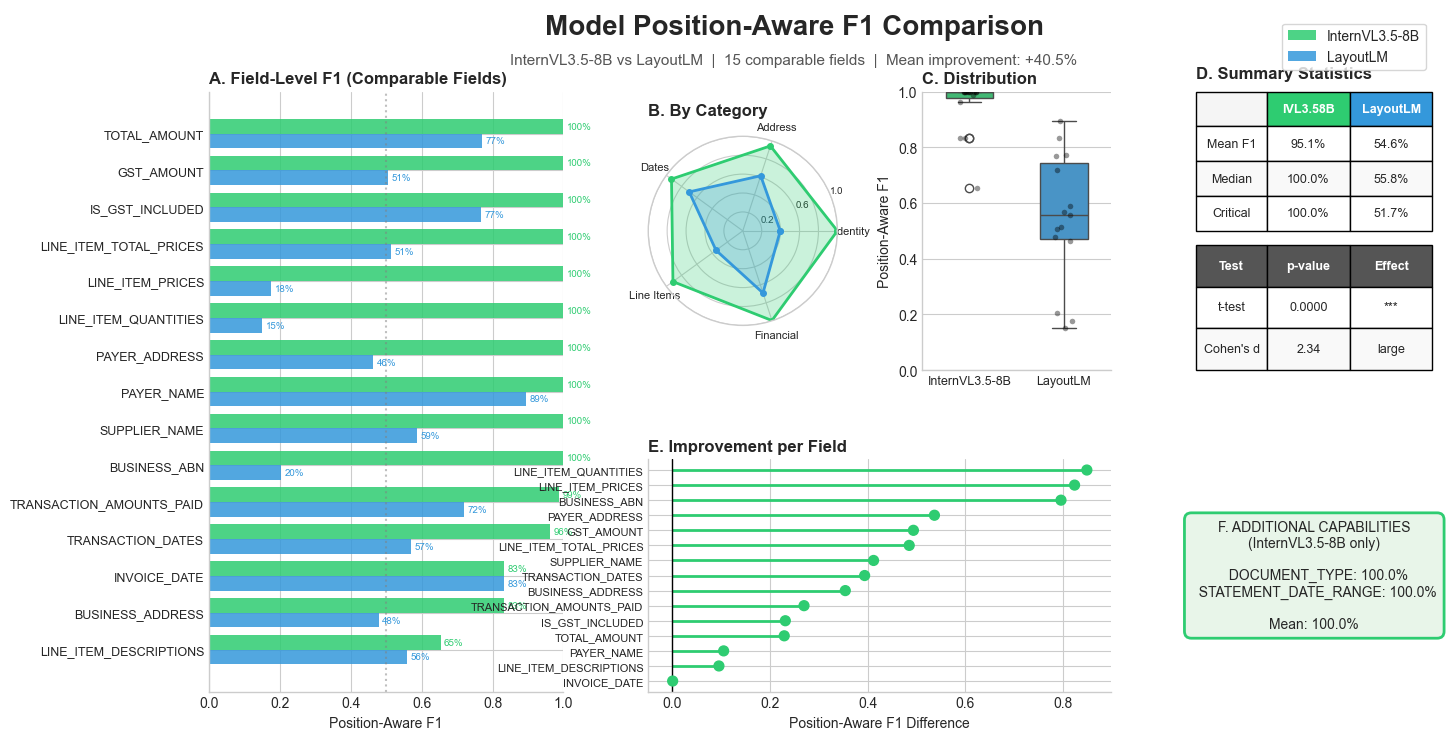

In [53]:
# =============================================================================
# LANDSCAPE DASHBOARD - Slide presentation format (16:9)
# =============================================================================
# 16:9 aspect ratio: 13.3 x 7.5 inches

fig = plt.figure(figsize=(13.3, 7.5), facecolor='white')

# Create grid: 2 rows, 4 columns
gs = fig.add_gridspec(2, 4, height_ratios=[1.2, 1], width_ratios=[1.5, 0.8, 0.8, 1],
                      hspace=0.35, wspace=0.35, top=0.88, bottom=0.08, left=0.06, right=0.98)

# Colors
colors_current = '#2ecc71'
colors_competing = '#3498db'

# --- Title & Legend (top) ---
ax_title = fig.add_axes([0.02, 0.91, 0.96, 0.08])
ax_title.axis('off')
ax_title.text(0.5, 0.7, 'Model Position-Aware F1 Comparison', 
              fontsize=20, fontweight='bold', ha='center', va='center')
ax_title.text(0.5, 0.15, 
              f'{CURRENT_MODEL_NAME} vs {COMPETING_MODEL_NAME}  |  '
              f'{metrics["n_fields_compared"]} comparable fields  |  '
              f'Mean improvement: {metrics["mean_difference"]:+.1%}', 
              fontsize=11, ha='center', va='center', color='#555')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors_current, alpha=0.85, label=CURRENT_MODEL_NAME),
    Patch(facecolor=colors_competing, alpha=0.85, label=COMPETING_MODEL_NAME)
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98),
           ncol=1, fontsize=10, frameon=True, fancybox=True)

# --- Panel A: Field-level comparison (left, spans 2 rows) ---
ax1 = fig.add_subplot(gs[:, 0])
plot_sorted = plot_df.sort_values('current_accuracy', ascending=True)
y_pos = np.arange(len(plot_sorted))

ax1.barh(y_pos + 0.2, plot_sorted['current_accuracy'], 0.4, 
         label=CURRENT_MODEL_NAME, color=colors_current, alpha=0.85)
ax1.barh(y_pos - 0.2, plot_sorted['competing_accuracy'], 0.4,
         label=COMPETING_MODEL_NAME, color=colors_competing, alpha=0.85)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(plot_sorted['field'], fontsize=9)
ax1.set_xlabel('Position-Aware F1', fontsize=10)
ax1.set_xlim(0, 1)
ax1.set_title('A. Field-Level F1 (Comparable Fields)', fontsize=12, fontweight='bold', loc='left')
ax1.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
sns.despine(ax=ax1)

# Add percentage labels
for i, (_, row) in enumerate(plot_sorted.iterrows()):
    ax1.text(row['current_accuracy'] + 0.01, i + 0.2, f"{row['current_accuracy']:.0%}", 
             va='center', ha='left', fontsize=7, color=colors_current)
    ax1.text(row['competing_accuracy'] + 0.01, i - 0.2, f"{row['competing_accuracy']:.0%}", 
             va='center', ha='left', fontsize=7, color=colors_competing)

# --- Panel B: Radar Chart (top middle) ---
ax2 = fig.add_subplot(gs[0, 1], polar=True)

cat_data = []
for cat, fields in FIELD_CATEGORIES.items():
    cat_df_temp = comparison_df[comparison_df['field'].isin(fields)]
    if len(cat_df_temp) > 0:
        cat_data.append({
            'category': cat,
            'current': cat_df_temp['current_accuracy'].mean(),
            'competing': cat_df_temp['competing_accuracy'].mean()
        })

radar_df = pd.DataFrame(cat_data)
categories_list = radar_df['category'].tolist()
N = len(categories_list)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

values_current = radar_df['current'].tolist()
values_current += values_current[:1]
ax2.plot(angles, values_current, 'o-', linewidth=2, color=colors_current, markersize=4)
ax2.fill(angles, values_current, alpha=0.25, color=colors_current)

values_competing = radar_df['competing'].tolist()
values_competing += values_competing[:1]
ax2.plot(angles, values_competing, 'o-', linewidth=2, color=colors_competing, markersize=4)
ax2.fill(angles, values_competing, alpha=0.25, color=colors_competing)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories_list, fontsize=8)
ax2.set_ylim(0, 1)
ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_yticklabels(['0.2', '', '0.6', '', '1.0'], fontsize=7)
ax2.set_title('B. By Category', fontsize=12, fontweight='bold', loc='left', pad=15)

# --- Panel C: Distribution (top right-middle) ---
ax3 = fig.add_subplot(gs[0, 2])
box_df = pd.DataFrame({
    'Model': [CURRENT_MODEL_NAME] * len(plot_df) + [COMPETING_MODEL_NAME] * len(plot_df),
    'F1': list(plot_df['current_accuracy']) + list(plot_df['competing_accuracy'])
})

sns.boxplot(data=box_df, x='Model', y='F1', ax=ax3, 
            palette=[colors_current, colors_competing], width=0.5)
sns.stripplot(data=box_df, x='Model', y='F1', ax=ax3,
              color='black', alpha=0.4, size=4, jitter=0.1)

ax3.set_ylim(0, 1)
ax3.set_xlabel('')
ax3.set_ylabel('Position-Aware F1', fontsize=10)
ax3.set_title('C. Distribution', fontsize=12, fontweight='bold', loc='left')
ax3.tick_params(axis='x', labelsize=9)
sns.despine(ax=ax3)

# --- Panel D: Summary Statistics (top right) ---
ax4 = fig.add_subplot(gs[0, 3])
ax4.axis('off')

current_short = CURRENT_MODEL_NAME.replace('InternVL', 'IVL').replace('-', '')
competing_short = COMPETING_MODEL_NAME

metrics_data = [
    ['', current_short, competing_short],
    ['Mean F1', f"{metrics['current_mean']:.1%}", f"{metrics['competing_mean']:.1%}"],
    ['Median', f"{metrics['current_median']:.1%}", f"{metrics['competing_median']:.1%}"],
    ['Critical', f"{metrics['critical_current_mean']:.1%}", f"{metrics['critical_competing_mean']:.1%}"],
]

stats_data = [
    ['Test', 'p-value', 'Effect'],
    ['t-test', f"{stat_results['paired_ttest']['pvalue']:.4f}", 
     '***' if stat_results['paired_ttest']['pvalue'] < 0.001 else ('**' if stat_results['paired_ttest']['pvalue'] < 0.01 else ('*' if stat_results['paired_ttest']['pvalue'] < 0.05 else 'ns'))],
    ["Cohen's d", f"{stat_results['cohens_d']:.2f}", effect_interp],
]

table1 = ax4.table(cellText=metrics_data, loc='upper center', cellLoc='center',
                   colWidths=[0.3, 0.35, 0.35], bbox=[0, 0.5, 1, 0.5])
table1.auto_set_font_size(False)
table1.set_fontsize(9)

for j in range(3):
    table1[(0, j)].set_facecolor(colors_current if j == 1 else (colors_competing if j == 2 else '#f5f5f5'))
    table1[(0, j)].set_text_props(fontweight='bold', color='white' if j > 0 else 'black')
for i in range(1, 4):
    for j in range(3):
        table1[(i, j)].set_facecolor('#f9f9f9' if i % 2 == 0 else 'white')

table2 = ax4.table(cellText=stats_data, loc='lower center', cellLoc='center',
                   colWidths=[0.3, 0.35, 0.35], bbox=[0, 0, 1, 0.45])
table2.auto_set_font_size(False)
table2.set_fontsize(9)

for j in range(3):
    table2[(0, j)].set_facecolor('#555555')
    table2[(0, j)].set_text_props(fontweight='bold', color='white')
for i in range(1, 3):
    for j in range(3):
        table2[(i, j)].set_facecolor('#f9f9f9' if i % 2 == 0 else 'white')

ax4.set_title('D. Summary Statistics', fontsize=12, fontweight='bold', loc='left', pad=10)

# --- Panel E: Improvement per Field (bottom middle-left) ---
ax5 = fig.add_subplot(gs[1, 1:3])
diff_sorted = plot_df.sort_values('difference')
y_diff = np.arange(len(diff_sorted))
diff_colors = [colors_current if d >= 0 else '#e74c3c' for d in diff_sorted['difference']]

ax5.hlines(y=y_diff, xmin=0, xmax=diff_sorted['difference'], color=diff_colors, linewidth=2)
ax5.scatter(diff_sorted['difference'], y_diff, color=diff_colors, s=50, zorder=3)
ax5.axvline(x=0, color='black', linewidth=1)

ax5.set_yticks(y_diff)
ax5.set_yticklabels(diff_sorted['field'], fontsize=8)
ax5.set_xlabel('Position-Aware F1 Difference', fontsize=10)
ax5.set_title('E. Improvement per Field', fontsize=12, fontweight='bold', loc='left')
ax5.set_xlim(min(diff_sorted['difference']) - 0.05, max(diff_sorted['difference']) + 0.05)
sns.despine(ax=ax5)

# --- Panel F: Additional Capabilities (bottom right) ---
ax6 = fig.add_subplot(gs[1, 3])
ax6.axis('off')

exc_lines = ["F. ADDITIONAL CAPABILITIES", f"({CURRENT_MODEL_NAME} only)", ""]
if len(exclusive_df) > 0:
    for _, row in exclusive_df.iterrows():
        acc_str = f"{row['current_accuracy']:.1%}" if pd.notna(row['current_accuracy']) else "N/A"
        exc_lines.append(f"  {row['field']}: {acc_str}")
    if not np.isnan(metrics.get('exclusive_mean', np.nan)):
        exc_lines.append("")
        exc_lines.append(f"Mean: {metrics['exclusive_mean']:.1%}")
else:
    exc_lines.append("None")
exc_text = chr(10).join(exc_lines)

ax6.text(0.5, 0.5, exc_text, transform=ax6.transAxes, fontsize=10,
         ha='center', va='center',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#e8f5e9', edgecolor='#2ecc71', linewidth=2))

plt.savefig(OUTPUT_DIR / 'comparison_dashboard_landscape.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
print(f"Saved: {OUTPUT_DIR / 'comparison_dashboard_landscape.png'}")
plt.show()

---
## 9. Export Results

In [54]:
# Generate summary report with Additional Capabilities and F1 section
report = f"""# Model Accuracy Comparison Report

## Overview
- **Current Model**: {CURRENT_MODEL_NAME}
- **Competing Model**: {COMPETING_MODEL_NAME}
- **Comparable Fields**: {metrics['n_fields_compared']}
- **Fields with F1 Comparison**: {metrics['n_fields_with_f1']}
- **Additional Capabilities** (our model only): {metrics['n_exclusive_fields']}
- **Document Types**: Invoices, Receipts, Bank Statements (195 documents)

## Summary Statistics (Comparable Fields Only)

### Accuracy Metrics

| Metric | {CURRENT_MODEL_NAME} | {COMPETING_MODEL_NAME} |
|--------|-----------|----------|
| Mean Accuracy | {metrics['current_mean']:.1%} | {metrics['competing_mean']:.1%} |
| Median Accuracy | {metrics['current_median']:.1%} | {metrics['competing_median']:.1%} |
| Std Dev | {metrics['current_std']:.1%} | {metrics['competing_std']:.1%} |
| Min | {metrics['current_min']:.1%} | {metrics['competing_min']:.1%} |
| Max | {metrics['current_max']:.1%} | {metrics['competing_max']:.1%} |
"""

# Add F1 metrics if available
if metrics['n_fields_with_f1'] > 0:
    report += f"""
### F1 Score Metrics (Position-Agnostic)

| Metric | {CURRENT_MODEL_NAME} | {COMPETING_MODEL_NAME} |
|--------|-----------|----------|
| Mean F1 | {metrics['current_f1_mean']:.1%} | {metrics['competing_f1_mean']:.1%} |
| Mean F1 Difference | {metrics['f1_mean_difference']:+.1%} | - |
| Fields {CURRENT_MODEL_NAME} Better | {metrics['f1_fields_current_better']} | - |
| Fields {COMPETING_MODEL_NAME} Better | {metrics['f1_fields_competing_better']} | - |

*Note: F1 scores are position-agnostic (set-based matching) for fair comparison between models.*
"""

report += f"""
## Comparison Results

- **Mean Accuracy Difference**: {metrics['mean_difference']:+.1%} (positive = {CURRENT_MODEL_NAME} better)
- **Fields where {CURRENT_MODEL_NAME} better**: {metrics['fields_current_better']}
- **Fields where {COMPETING_MODEL_NAME} better**: {metrics['fields_competing_better']}
- **Fields equal**: {metrics['fields_equal']}

## Critical Fields Analysis

Critical fields: {', '.join(CRITICAL_FIELDS)}

- **{CURRENT_MODEL_NAME} Mean**: {metrics['critical_current_mean']:.1%}
- **{COMPETING_MODEL_NAME} Mean**: {metrics['critical_competing_mean']:.1%}

## Statistical Significance

- **Paired t-test p-value**: {stat_results['paired_ttest']['pvalue']:.4f} ({'Significant' if stat_results['paired_ttest']['pvalue'] < 0.05 else 'Not significant'} at α=0.05)
- **Wilcoxon test p-value**: {stat_results['wilcoxon']['pvalue']:.4f} ({'Significant' if stat_results['wilcoxon']['pvalue'] < 0.05 else 'Not significant'} at α=0.05)
- **Cohen's d effect size**: {stat_results['cohens_d']:.4f} ({effect_interp})
- **95% CI for difference**: [{stat_results['bootstrap_ci_95'][0]:+.1%}, {stat_results['bootstrap_ci_95'][1]:+.1%}]

## Field-Level Details (Comparable Fields)

### Accuracy
| Field | {CURRENT_MODEL_NAME} | {COMPETING_MODEL_NAME} | Difference | Critical |
|-------|-----------|----------|------------|----------|
"""

for _, row in comparable_df.iterrows():
    curr = f"{row['current_accuracy']:.1%}" if pd.notna(row['current_accuracy']) else "N/A"
    comp = f"{row['competing_accuracy']:.1%}" if pd.notna(row['competing_accuracy']) else "N/A"
    diff = f"{row['difference']:+.1%}" if pd.notna(row['difference']) else "N/A"
    critical = "Yes" if row['is_critical'] else ""
    report += f"| {row['field']} | {curr} | {comp} | {diff} | {critical} |\n"

# Add F1 table if available
f1_data = comparable_df.dropna(subset=['current_f1', 'competing_f1'])
if len(f1_data) > 0:
    report += f"""
### F1 Scores (Position-Agnostic)
| Field | {CURRENT_MODEL_NAME} F1 | {COMPETING_MODEL_NAME} F1 | Difference |
|-------|-----------|----------|------------|
"""
    for _, row in f1_data.iterrows():
        curr_f1 = f"{row['current_f1']:.1%}" if pd.notna(row['current_f1']) else "N/A"
        comp_f1 = f"{row['competing_f1']:.1%}" if pd.notna(row['competing_f1']) else "N/A"
        diff_f1 = f"{row['f1_difference']:+.1%}" if pd.notna(row['f1_difference']) else "N/A"
        report += f"| {row['field']} | {curr_f1} | {comp_f1} | {diff_f1} |\n"

# Add Additional Capabilities section
if metrics['n_exclusive_fields'] > 0:
    report += f"""
## Additional Capabilities ({CURRENT_MODEL_NAME} Only)

The following fields are **unique to our model** and not available in the competing model:

| Field | {CURRENT_MODEL_NAME} Accuracy | Category |
|-------|------------------|----------|
"""
    for _, row in exclusive_df.iterrows():
        acc = f"{row['current_accuracy']:.1%}" if pd.notna(row['current_accuracy']) else "N/A"
        report += f"| {row['field']} | {acc} | {row['category']} |\n"
    
    if not np.isnan(metrics['exclusive_mean']):
        report += f"\n**Mean accuracy of exclusive capabilities**: {metrics['exclusive_mean']:.1%}\n"

report += f"""
## Output Files

- `comparison_dashboard_a4.png` - A4 dashboard summary (300 dpi)
- `comparison_dashboard_a4.pdf` - A4 dashboard PDF
- `comparison_report.md` - This report
- `accuracy_comparison_bars.png` - Side-by-side bar chart
- `accuracy_difference_lollipop.png` - Difference visualization
- `accuracy_radar_chart.png` - Category radar chart
- `accuracy_heatmap.png` - Heatmap comparison
- `accuracy_boxplot.png` - Distribution comparison
- `accuracy_scatter.png` - Scatter plot with identity line
- `accuracy_by_category.png` - Category comparison chart
- `f1_comparison.png` - F1 score comparison (if F1 data available)
"""

# Save report
report_path = OUTPUT_DIR / 'comparison_report.md'
with open(report_path, 'w') as f:
    f.write(report)

print(f"Saved: {report_path}")
print("\n" + "=" * 60)
print("COMPARISON COMPLETE")
print("=" * 60)

Saved: ../output/comparison/comparison_report.md

COMPARISON COMPLETE


---
## 10. Quick Reference: Data Format Requirements

### CSV File Formats

**competing_model_accuracy.csv:**
```csv
Subset,Field,F1,Exclusive
Invoices & receipts,BUSINESS_ABN,0.204081633,FALSE
Invoices & receipts,SUPPLIER_NAME,0.587926509,FALSE
Bank statements,TRANSACTION_DATES,0.56918239,FALSE
...
```

**current_model_accuracy.csv:**
```csv
Subset,Field,F1,Precision,Recall,Exclusive
Invoices & receipts,DOCUMENT_TYPE,0.728205128,0.728205128,0.728205,TRUE
Invoices & receipts,BUSINESS_ABN,0.851282051,0.851282051,0.851282,FALSE
Bank statements,TRANSACTION_DATES,0.925574861,0.94022792,0.928886,FALSE
...
```

### Column Descriptions

| Column | Description |
|--------|-------------|
| Subset | Document category: "Invoices & receipts" or "Bank statements" |
| Field | Schema field name (e.g., BUSINESS_ABN, TOTAL_AMOUNT) |
| F1 | F1 score (primary comparison metric) |
| Precision | Precision score (optional) |
| Recall | Recall score (optional) |
| Exclusive | TRUE if field is exclusive to our model (not in competing model) |

### F1 Calculation Method

All F1 scores are computed using `calculate_field_accuracy_f1()` from `common/evaluation_metrics.py`.

#### Single-Value Fields
- **Text fields** (SUPPLIER_NAME, BUSINESS_ADDRESS): Levenshtein distance with ANLS-style 0.5 threshold
- **ID fields** (BUSINESS_ABN): Exact match after normalization (remove spaces, dashes, prefixes)
- **Monetary fields** (TOTAL_AMOUNT, GST_AMOUNT): Numeric comparison with 1% tolerance
- **Boolean fields** (IS_GST_INCLUDED): Case-insensitive boolean parsing
- **Date fields** (INVOICE_DATE, STATEMENT_DATE_RANGE): Semantic date parsing supporting ranges and format variations

#### List Fields (Pipe-Separated Values)
Uses **POSITION-AWARE (order-aware) F1 matching**:

```
Extracted:    ["apple", "banana", "cherry"]
Ground Truth: ["banana", "apple", "cherry"]
Result:       33.3% F1 (only position 2 matches)
```

**Position-by-position comparison:**
- Position i: extracted[i] vs ground_truth[i]
- Match at same position → TP (True Positive)
- Mismatch at same position → FN (False Negative) 
- Extra extracted items → FP (False Positive)
- Missing ground truth items → FN (False Negative)

**Metrics:**
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)  
- F1 = 2 × (Precision × Recall) / (Precision + Recall)

**List field matching by type:**
- **Monetary lists** (LINE_ITEM_PRICES): Numeric comparison with 1% tolerance
- **Quantity lists** (LINE_ITEM_QUANTITIES): Integer comparison
- **Text lists** (LINE_ITEM_DESCRIPTIONS): Fuzzy text matching (0.75 word overlap threshold)
- **Transaction lists** (TRANSACTION_DATES, TRANSACTION_AMOUNTS_PAID): Type-specific matching

### Data Sources

- **per_field_metrics.csv** - Generated by `model_comparison_reporter_v2.ipynb`
- **harvest_model_accuracy.ipynb** - Exports per-model CSV files from per_field_metrics.csv